In [179]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf, gamma, gammainc
import yfinance as yf
from tqdm import tqdm
from scipy.optimize import minimize
from scipy.stats import norm

# Problem 1

### 1

Fokker-Plank eqation:
$$\frac{dP(x, t)}{dt} = D\frac{d^2P(x, t)}{dx^2},\\ s.t.\ P(0, t)=P(\infty, t)=0,\\ P(x, 0) = \delta(x-x_0)$$

### 2

Let's check function:
$$\hat{P}(x, t) = \frac{1}{\sqrt{4\pi Dt}}e^{-\frac{(x-x_0)^2}{4Dt}}$$
$$\frac{d\hat{P}(x, t)}{dt} = -\frac{1}{2}\frac{1}{\sqrt{4\pi Dt^3}}e^{-\frac{(x-x_0)^2}{4Dt}} + \frac{1}{\sqrt{4\pi Dt}}e^{-\frac{(x-x_0)^2}{4Dt}}*\frac{(x-x_0)^2}{4Dt^2}$$
$$\frac{d\hat{P}(x, t)}{dx} = \frac{1}{\sqrt{4\pi Dt}}e^{-\frac{(x-x_0)^2}{4Dt}}*-\frac{x-x_0}{2Dt}$$
$$\frac{d^2\hat{P}(x, t)}{dx^2} = \frac{1}{\sqrt{4\pi Dt}}e^{-\frac{(x-x_0)^2}{4Dt}}*\frac{(x-x_0)^2}{4D^2t^2} - \frac{1}{2Dt}\frac{1}{\sqrt{4\pi Dt}}e^{-\frac{(x-x_0)^2}{4Dt}}$$
Thus, this function satisfies equation and condition $\hat{P}(\infty, t) = 0$. To satisfy condition $P(0, t) = 0$ we can use method of images: in our case we can add negative PDF $P^{'}(x, t) = -\frac{1}{\sqrt{4\pi Dt}}e^{-\frac{(x+x_0)^2}{4Dt}}$ to $\hat{P}(x, t)$:
$$P(x, t) = \frac{1}{\sqrt{4\pi Dt}}e^{-\frac{(x-x_0)^2}{4Dt}} - \frac{1}{\sqrt{4\pi Dt}}e^{-\frac{(x+x_0)^2}{4Dt}}$$

### 3

$$S(t) = \int\limits_0^{+\infty} P(x, t)dx = \int\limits_0^{+\infty} \frac{1}{\sqrt{4\pi Dt}}e^{-\frac{(x-x_0)^2}{4Dt}} - \frac{1}{\sqrt{4\pi Dt}}e^{-\frac{(x+x_0)^2}{4Dt}}dx = \\ = \int\limits_0^{+\infty} \frac{1}{\sqrt{4\pi Dt}}e^{-\frac{(x-x_0)^2}{4Dt}}dx - \int\limits_0^{+\infty}\frac{1}{\sqrt{4\pi Dt}}e^{-\frac{(x+x_0)^2}{4Dt}}dx = \int\limits_0^{+\infty} \frac{1}{\sqrt{\pi}}e^{-\frac{(x-x_0)^2}{4Dt}}d\frac{x-x_0}{\sqrt{4Dt}} - \int\limits_0^{+\infty} \frac{1}{\sqrt{\pi}}e^{-\frac{(x+x_0)^2}{4Dt}}d\frac{x+x_0}{\sqrt{4Dt}} = \\ = \int\limits_{-x_0/\sqrt{4Dt}}^{+\infty} \frac{1}{\sqrt{\pi}}e^{-z^2}dz - \int\limits_{x_0/\sqrt{4Dt}}^{+\infty} \frac{1}{\sqrt{\pi}}e^{-z^2}dz = \int\limits_{-x_0/\sqrt{4Dt}}^{x_0/\sqrt{4Dt}} \frac{1}{\sqrt{\pi}}e^{-z^2}dz = \frac{2}{\sqrt{\pi}}\int\limits_{0}^{x_0/\sqrt{4Dt}}e^{-z^2}dz = erf(\frac{x_0}{\sqrt{4Dt}})$$

### 4

For this Fokker-Plank equation:
$$\frac{dP(x, t)}{dt} = D\frac{d^2P(x, t)}{dx^2} = \frac{1}{2}\frac{d^2(2D*P(x, t))}{dx^2}$$
Exist corresponding SDE:
$$dX_t = \sqrt{2D}dW_t$$
Now, let's see simulation results.

In [3]:
def path_generator(n_paths, n_steps, T, D, X_0):

    Z = np.random.normal(0.0, 1.0, [n_paths, n_steps + 1])
    time = np.linspace(0, T, n_steps+1, endpoint=True)
    dt = T / float(n_steps)
    X = X_0 + np.cumsum(Z, axis=1) * np.sqrt(2*D*dt)

    S = np.empty_like(X)
    S[:, 0] = 1

    for k in range(0, n_steps):
        S[:, k+1] = (X[:, k+1] >= 0) & (S[:, k] == 1)

    return X, S, time

In [4]:
def S_t(t, x_0=1, D=1):
    return erf(x_0 / (4 * D * t)**0.5)

In [5]:
np.random.seed(0)
n_paths = 500
n_steps = 10000
T = 10
D = 1
X_0 = 1

X, S, time = path_generator(n_paths, n_steps, T, D, X_0)

/tmp/ipykernel_1409/3651921585.py:2: RuntimeWarning: divide by zero encountered in divide
  return erf(x_0 / (4 * D * t)**0.5)


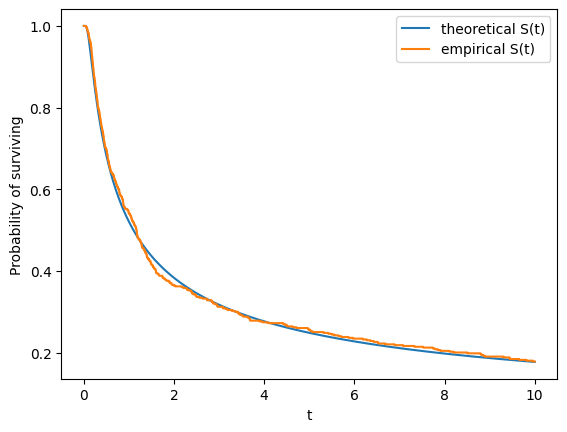

In [6]:
plt.plot(time, S_t(time), label='theoretical S(t)')
plt.plot(time, S.mean(0), label='empirical S(t)')
plt.xlabel('t')
plt.ylabel('Probability of surviving')

plt.legend()
plt.show()

# Problem 2

### 1

[*********************100%%**********************]  1 of 1 completed


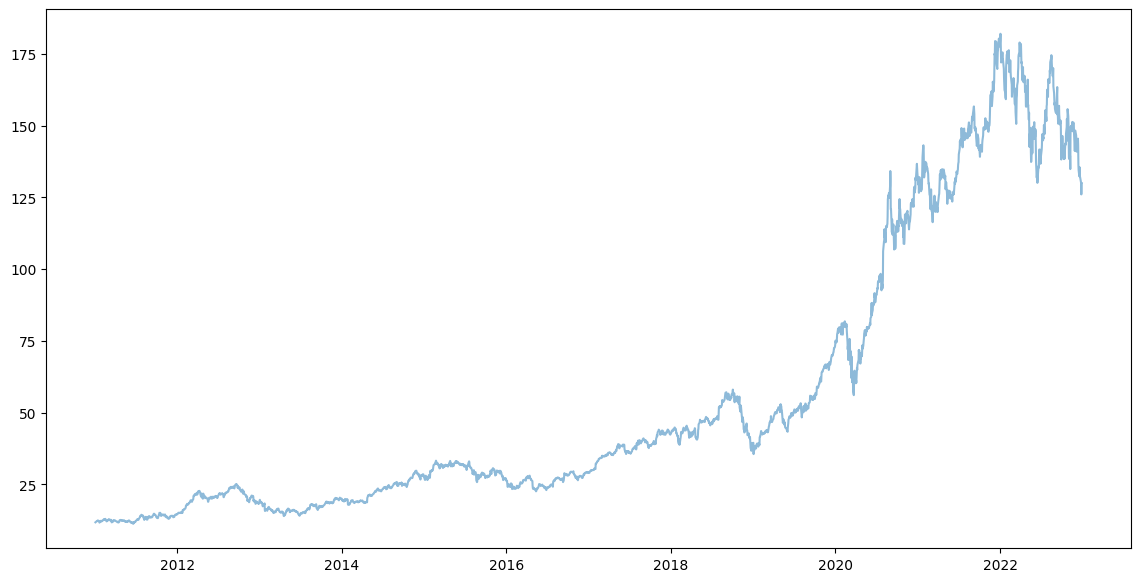

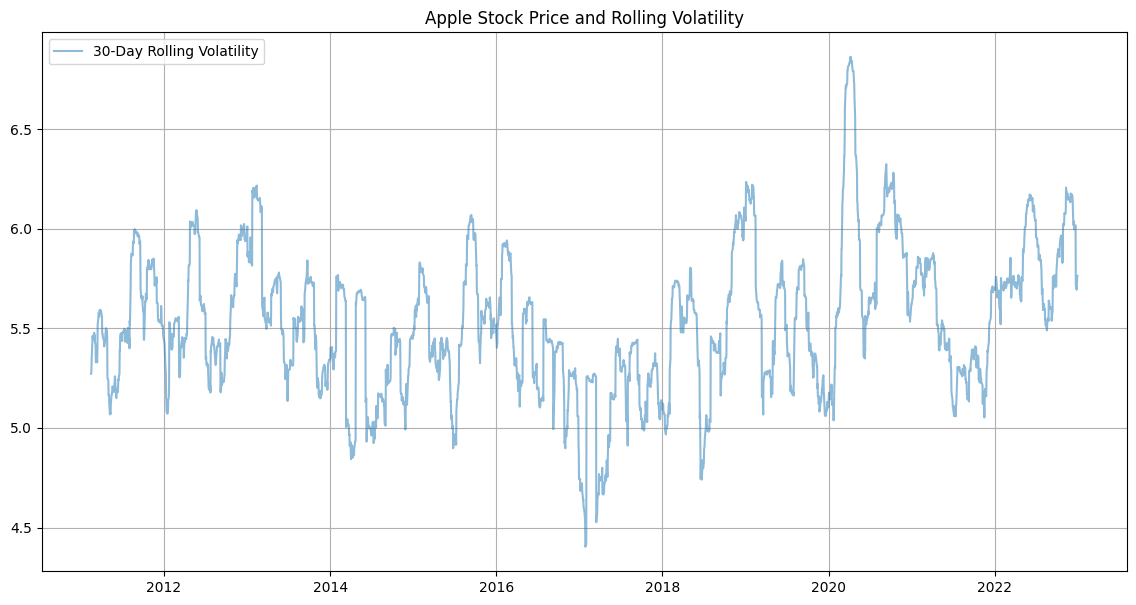

In [447]:
apple_data = yf.download('AAPL', start='2011-01-01', end='2022-12-31')  
apple_data['Return'] = apple_data['Close'].pct_change()  
apple_data['Rolling Volatility'] = apple_data['Return'].rolling(window=30).std() * np.sqrt(252)
   
plt.figure(figsize=(14, 7))  
plt.plot(apple_data['Close'], label='Apple', alpha=0.5)  

plt.figure(figsize=(14, 7))  
plt.plot(np.log(1+1000*apple_data['Rolling Volatility']), label='30-Day Rolling Volatility', alpha=0.5)  
  
plt.legend(loc='upper left')  
plt.title('Apple Stock Price and Rolling Volatility')  
plt.grid(True)  
plt.show()  


In [448]:
apple_volatility = apple_data['Rolling Volatility'].values[30:]
apple_prices = apple_data['Close'].values[30:]

In [449]:
def heston_model(dt, mu, kappa, theta, sigma, rho, S0, v0, n_steps, n_paths):
    S = np.zeros((n_steps+1, n_paths))  
    v = np.zeros((n_steps+1, n_paths))  
    S[0] = S0 
    v[0] = v0  
    
    dW1 = np.random.normal(0, np.sqrt(dt), size=(n_steps, n_paths)) 
    dW2 = rho*dW1 + np.sqrt(1-rho**2) * np.random.normal(0, np.sqrt(dt), size=(n_steps, n_paths))
    for i in range(n_steps):
        #print(v[i], S[i], dW2[i], dW1[i])
        v[i+1] = np.maximum(v[i] + kappa * (theta-v[i]) * dt + sigma * np.sqrt(v[i]) * dW2[i], 0)
        S[i+1] = S[i] + mu * S[i] * dt + np.sqrt(v[i]) * S[i] * dW1[i]
    
    return S, v

def heston_model_last(dt, mu, kappa, theta, sigma, rho, S0, v0, n_steps, n_paths):
    S = np.zeros(n_paths) + S0
    v = np.zeros(n_paths) + v0
    
    dW1 = np.random.normal(0, np.sqrt(dt), size=(n_steps, n_paths)) 
    dW2 = rho*dW1 + np.sqrt(1-rho**2) * np.random.normal(0, np.sqrt(dt), size=(n_steps, n_paths))
    for i in range(n_steps):
        v = np.maximum(v + kappa * (theta-v) * dt + sigma * np.sqrt(v) * dW2[i], 0)
        S = S + mu * S * dt + np.sqrt(v) * S * dW1[i]
    
    return S, v

In [468]:
np.random.seed(4)

kappa = 20
theta = apple_volatility.mean()
sigma = 1
rho = -0.8
v0 = apple_volatility[0]
mu = 1.2
S0 = apple_prices[0]

T = 2
N = apple_volatility.shape[0]  
dt = T / N

S, v = heston_model(dt, mu, kappa, theta, sigma, rho, S0, v0, N, 1)

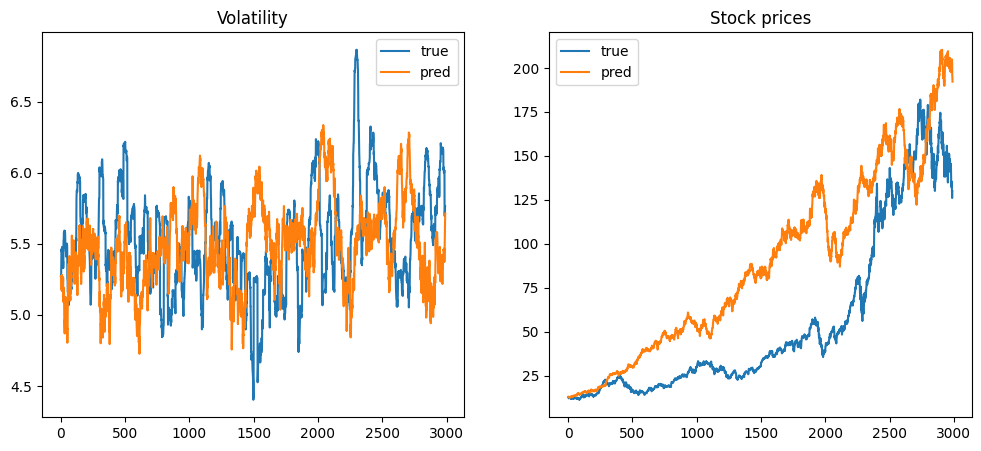

In [466]:
S, v = S.reshape(-1, ), v.reshape(-1, )

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(np.log(1+1000 * apple_volatility), label='true')
axes[0].plot(np.log(1+1000 * v), label='pred')
axes[0].legend()
axes[0].set_title('Volatility')

axes[1].plot(apple_prices, label='true')
axes[1].plot(S, label='pred')
axes[1].legend()
axes[1].set_title('Stock prices')

plt.show()

### 2

In [467]:
np.random.seed(0)

N_PATHS = 1000
K = 130
option_prices = []

for ts in tqdm(range(N)):
    S0 = S[ts]
    v0 = v[ts]
    S_cur, v_cur = heston_model_last(dt, mu, kappa, theta, sigma, rho, S0, v0, N - ts, N_PATHS)
    mean_profit = np.clip(S_cur - K, 0, None).mean()
    option_prices.append(mean_profit)

100%|██████████| 2990/2990 [07:46<00:00,  6.40it/s] 


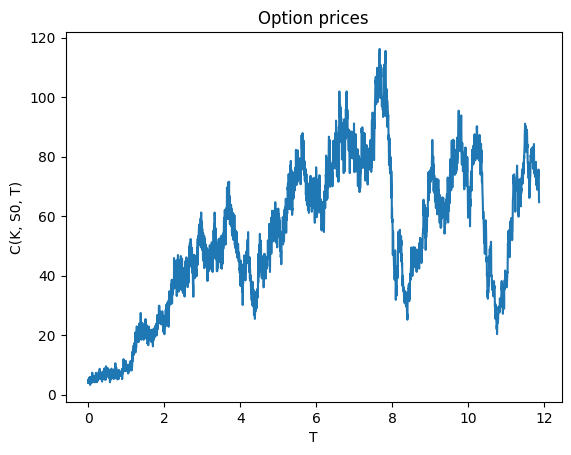

In [469]:
plt.plot(np.linspace(0, apple_prices.shape[0] / 252, N+1)[:-1], option_prices)

plt.title('Option prices')
plt.xlabel('T')
plt.ylabel('C(K, S0, T)')
plt.show()

### 3

In [470]:
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T) + 1e-10)
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [471]:
sigmas = []
r = 0.0

for i, option_price in enumerate(tqdm(option_prices)):
    func = lambda sigma: (black_scholes_call_price(S[i], K, T-i*dt, r, sigma) - option_price)**2
    bnds = ((0, None), )
    res = minimize(func, x0=(3, ), bounds=bnds, method='SLSQP')
    sigmas.append(res.x)

100%|██████████| 2990/2990 [00:15<00:00, 190.27it/s]


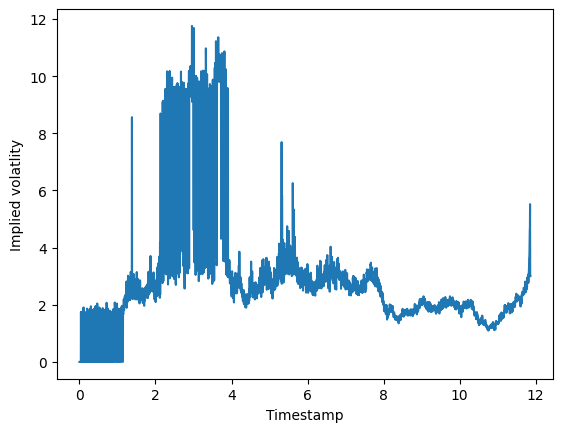

In [473]:
plt.plot(np.linspace(0, apple_prices.shape[0] / 252, N+1)[:-1], sigmas)
plt.xlabel('Timestamp')
plt.ylabel('Implied volatlity')
plt.show()

### 4

In [475]:
np.random.seed(0)

N_PATHS = 1000
option_prices = []

for ts in tqdm(range(N)):
    S0 = S[ts]
    v0 = v[ts]
    S_cur, v_cur = heston_model_last(dt, mu, kappa, theta, sigma, rho, S0, v0, N - ts, N_PATHS)
    option_prices.append(S_cur)

option_prices = np.array(option_prices)

100%|██████████| 2990/2990 [07:26<00:00,  6.70it/s] 


In [476]:
Ks = np.linspace(50, 400, 30)
t = np.linspace(0, apple_prices.shape[0] / 252, N+1)[:-1][::-1]
r = 0.0
sigmas = []

for K in tqdm(Ks):
    sigmas_cur = []
    mean_profits = np.clip(option_prices - K, 0, None).mean(1)
    for i, option_price in enumerate(mean_profits):
        func = lambda sigma: (black_scholes_call_price(S[i], K, T-i*dt, r, sigma) - option_price)**2
        bnds = ((0, None), )
        res = minimize(func, (3, ), method='SLSQP', bounds=bnds)
        sigmas_cur.append(res.x[0])
    sigmas.append(sigmas_cur)

sigmas = np.array(sigmas)

100%|██████████| 30/30 [04:00<00:00,  8.00s/it]


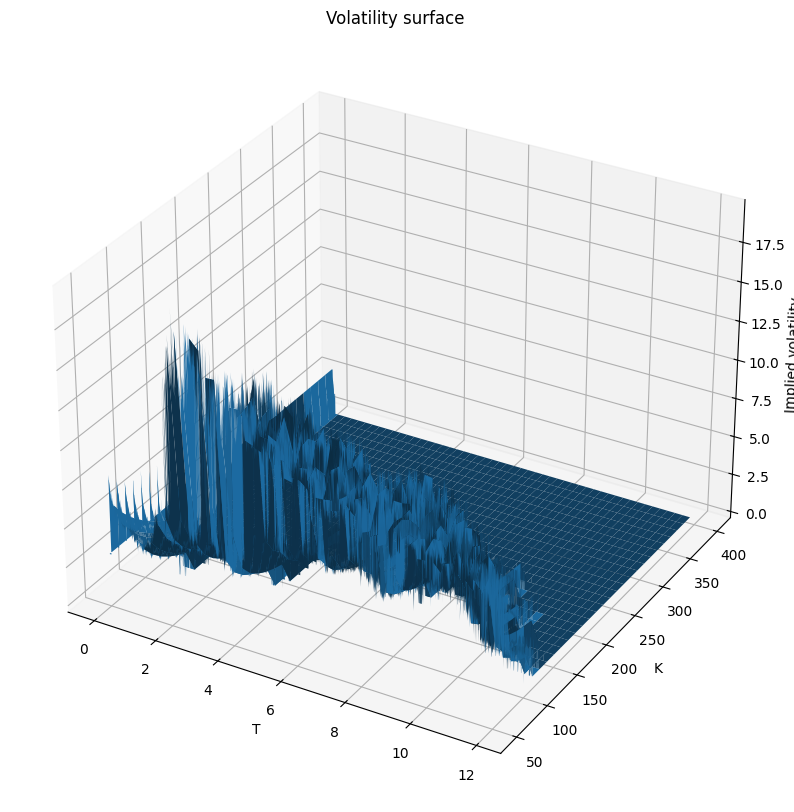

In [477]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection="3d")
x, y = np.meshgrid(t, Ks)

ax.plot_surface(x, y, sigmas)
ax.set_xlabel('T')
ax.set_ylabel('K')
ax.set_zlabel('Implied volatility')
ax.set_title('Volatility surface')

plt.show()

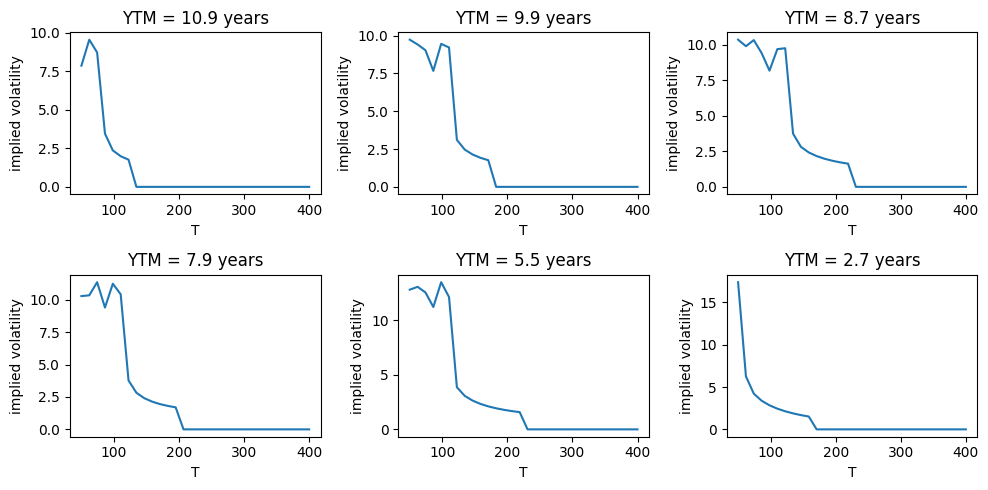

In [478]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))

for i, n in enumerate([250, 500, 800, 1000, 1600, 2300]):
    axes[i // 3][i % 3].plot(Ks, sigmas[:, n])
    axes[i // 3][i % 3].set_title('YTM = {:.1f} years'.format(t[n]))
    axes[i // 3][i % 3].set_xlabel('T')
    axes[i // 3][i % 3].set_ylabel('implied volatility')

plt.tight_layout()
plt.show()

It looks far from smile pattern. Obtained results are really noisy.

# Problem 3

### 1

$${}_0D_x^\alpha x^3 = \frac{1}{\Gamma(1 - \alpha)} \frac{d}{dx}\int\limits_0^x \frac{z^3}{(x-z)^\alpha}dz, \alpha < 1$$
$$\int\limits_0^x \frac{z^3}{(x-z)^\alpha}dz = \{x-z=t\}=\int\limits_0^x \frac{(x-t)^3}{t^\alpha}dt = \int\limits_0^x \frac{x^3 - 3x^2t+3xt^2-t^3}{t^\alpha}dt = (x^3\frac{1}{1-\alpha}t^{1-\alpha} - \\ - 3x^2\frac{1}{2-\alpha}t^{2-\alpha} + 3x \frac{1}{3-\alpha}t^{3-\alpha}-\frac{1}{4-\alpha}t^{4-\alpha})|_0^x = x^{4-\alpha}(\frac{1}{1-\alpha} - \frac{3}{2-\alpha} + \frac{3}{3-\alpha} - \frac{1}{4-\alpha})$$
$$\frac{dx^{4-\alpha}(\frac{1}{1-\alpha} - \frac{3}{2-\alpha} + \frac{3}{3-\alpha} - \frac{1}{4-\alpha})}{x} = x^{3-\alpha}(\frac{4-\alpha}{1-\alpha} - 3\frac{4-\alpha}{2-\alpha} + 3\frac{4-\alpha}{3-\alpha} - \frac{4-\alpha}{4-\alpha}) = \\ = x^{3-\alpha}(\frac{3}{1-\alpha} + 1 - 3(4-\alpha)(\frac{1}{2-\alpha} - \frac{1}{3-\alpha}) - 1) = 3x^{3-\alpha}(\frac{1}{1-\alpha} - \frac{4-\alpha}{(2-\alpha)(3-\alpha)}) = 3x^{3-\alpha}(\frac{2}{(1-\alpha)(2-\alpha)(3-\alpha)}) = \\ = \frac{3 * 2 * x^{3-\alpha}}{(1-\alpha)(2-\alpha)(3-\alpha)}$$
$${}_0D_x^\alpha x^3 = \frac{1}{\Gamma(1 - \alpha)}\frac{3 * 2 * x^{3-\alpha}}{(1-\alpha)(2-\alpha)(3-\alpha)} = \frac{\Gamma(4)}{\Gamma(4-\alpha)}x^{3-\alpha}$$

### 2

$${}_0D_x^\alpha e^x = \frac{1}{\Gamma(1 - \alpha)} \frac{d}{dx}\int\limits_0^x \frac{e^z}{(x-z)^\alpha}dz, \alpha < 1$$
$$\int\limits_0^x \frac{e^z}{(x-z)^\alpha}dz = \{x-z=t\} = \int\limits_0^x \frac{e^{x-t}}{t^\alpha}dt = e^x\int\limits_0^x e^{-t} t^{-\alpha}
dt$$
$$\frac{d}{dx}(e^x\int\limits_0^x e^{-t} t^{-\alpha}dt) = e^x\int\limits_0^x e^{-t} t^{-\alpha}dt + x^{-\alpha}$$
$${}_0D_x^\alpha e^x = \frac{1}{\Gamma(1 - \alpha)}(e^x\int\limits_0^x e^{-t} t^{-\alpha}dt + x^{-\alpha}) = \frac{1}{\Gamma(1 - \alpha)}(e^x\gamma(1-\alpha, x) + x^{-\alpha})$$
where $\gamma(1-\alpha, x)$ - lower incomplete gamma function.

In [7]:
def x_3_RL_derivative(x, alpha):
    return gamma(4) / gamma(4 - alpha) * x**(3-alpha)

def e_x_RL_derivative(x, alpha):
    return np.exp(x) * gammainc(1-alpha, x) + x**(-alpha) / gamma(1 - alpha)

/tmp/ipykernel_1409/3605288207.py:5: RuntimeWarning: divide by zero encountered in power
  return np.exp(x) * gammainc(1-alpha, x) + x**(-alpha) / gamma(1 - alpha)
/tmp/ipykernel_1409/3605288207.py:5: RuntimeWarning: divide by zero encountered in reciprocal
  return np.exp(x) * gammainc(1-alpha, x) + x**(-alpha) / gamma(1 - alpha)
/tmp/ipykernel_1409/3605288207.py:5: RuntimeWarning: invalid value encountered in divide
  return np.exp(x) * gammainc(1-alpha, x) + x**(-alpha) / gamma(1 - alpha)


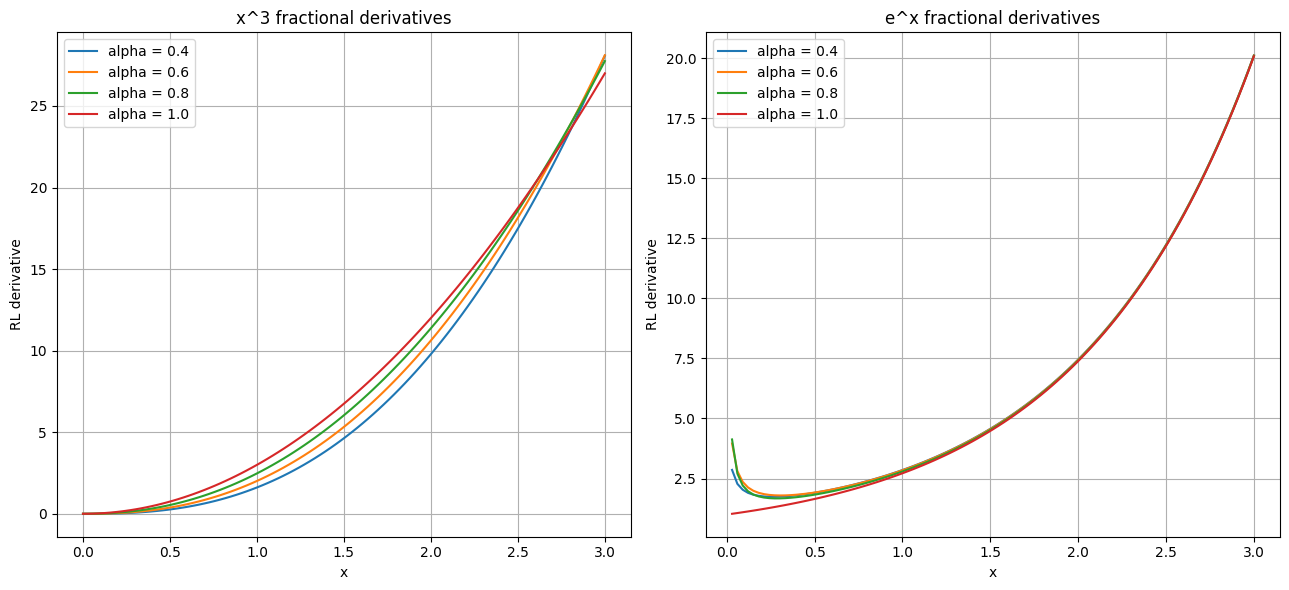

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6))
alphas = [0.4, 0.6, 0.8, 1.0]
x = np.linspace(0, 3, 100)

for alpha in alphas:
    axes[0].plot(x, x_3_RL_derivative(x, alpha), label=f'alpha = {alpha}')
    axes[1].plot(x, e_x_RL_derivative(x, alpha), label=f'alpha = {alpha}')

for ax in axes:
    ax.grid()
    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('RL derivative')

axes[0].set_title('x^3 fractional derivatives')
axes[1].set_title('e^x fractional derivatives')

plt.tight_layout()
plt.legend()
plt.show()

# Problem 4

### 1

In [2]:
def alpha_stable_sample(mu, w=1, size=1000):
    phi = np.random.uniform(-np.pi / 2, np.pi / 2, size=size)
    W = np.random.exponential(w, size=size)
    ksi = np.sin(mu * phi) / np.cos(phi)**(1 / mu) * (np.cos((1 - mu) * phi) / W)**((1 - mu) / mu)
    return ksi

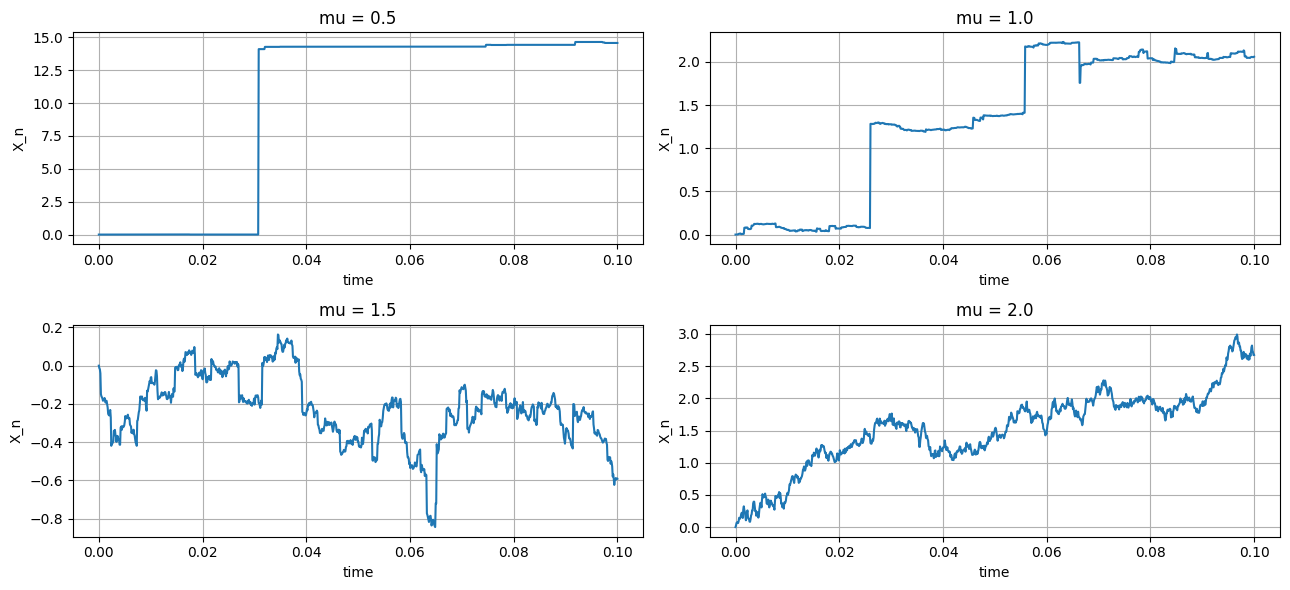

In [3]:
x0 = 0
K_mu = 1
t = np.linspace(0, 0.1, 1000)
dt = 0.001

mus = [0.5, 1.0, 1.5, 2.0]

fig, axes = plt.subplots(2, 2, figsize=(13, 6))

for i, mu in enumerate(mus):
    scale = (K_mu * dt)**(1 / mu)
    samples = alpha_stable_sample(mu, size=1000)
    samples[0] = x0
    mu_trajectory = scale * np.cumsum(samples)

    axes[i // 2][i % 2].plot(t, mu_trajectory)
    axes[i // 2][i % 2].grid()
    axes[i // 2][i % 2].set_title(f'mu = {mu}')
    axes[i // 2][i % 2].set_xlabel('time')
    axes[i // 2][i % 2].set_ylabel('X_n')

plt.tight_layout()
plt.show()

### 2

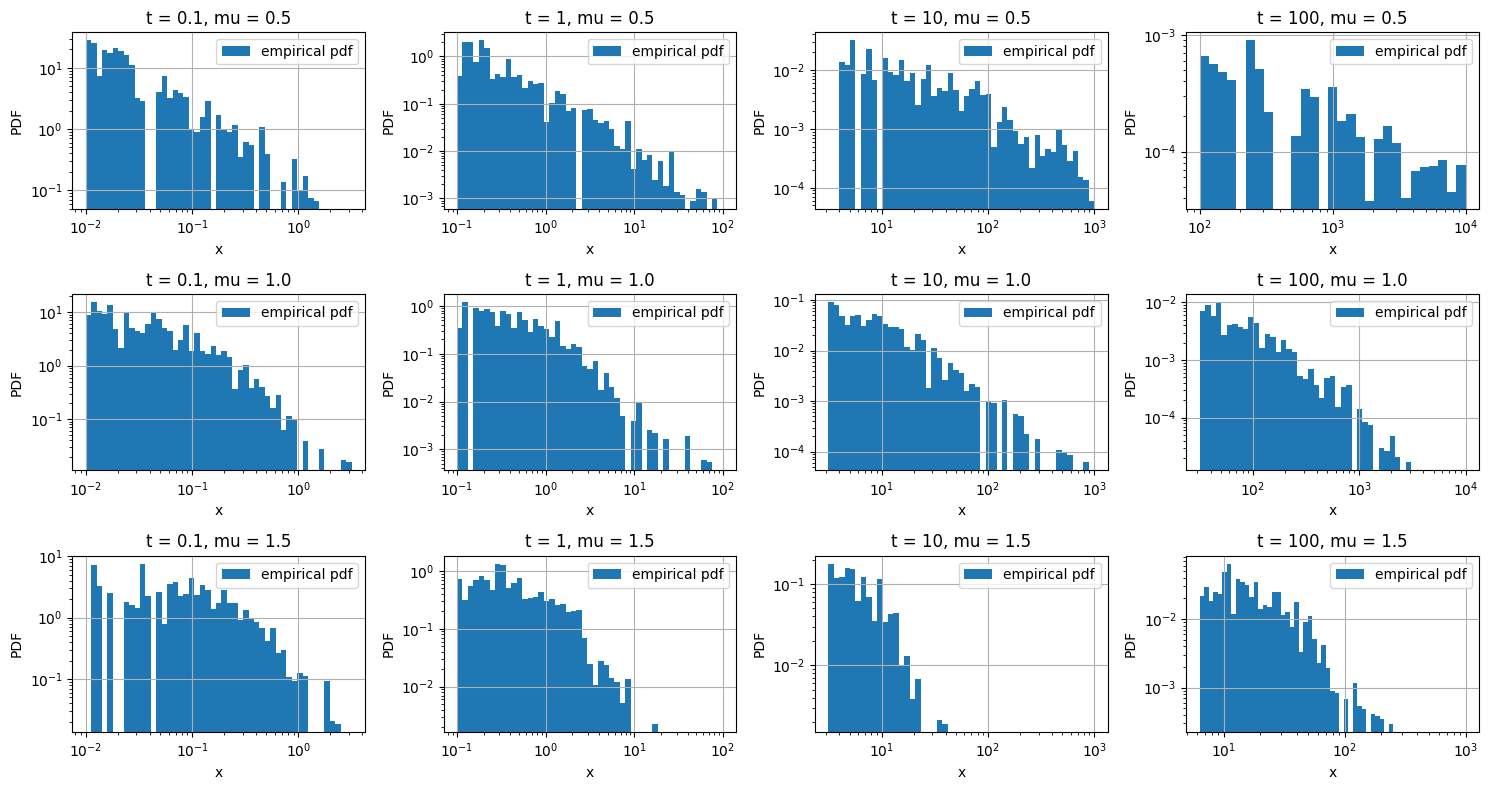

In [89]:
ts = [0.1, 1, 10, 100]
fig, axes = plt.subplots(len(mus) - 1, len(ts), figsize=(15, 8))
N = 2*10**2


for j, mu in enumerate(mus[:-1]):
    scale = (K_mu*dt)**(1 / mu)
    samples = alpha_stable_sample(mu, size=(N, int(ts[-1] / dt) + 1))
    samples[:, 0] = x0
    mu_trajectory = scale * np.cumsum(samples, axis=1)

    for i, t in enumerate(ts):
        idx = int(t // dt)
        bins = np.array([(1 + 1e-1)**n-1 for n in range(0, 200)])

        if t == 0.1:
            bins = 10**np.linspace(-2, 0.5, 50)
        elif t == 1:
            bins = 10**np.linspace(-1, 2, 50)
        elif t == 10:
            bins = 10**np.linspace(0.5, 3, 50)
        elif t == 100:
            if mu == 0.5:
                bins = 10**np.linspace(2, 4, 30)
            elif mu == 1:
                bins = 10**np.linspace(1.5, 4, 50)
            else:
                bins = 10**np.linspace(0.8, 3, 60)

        axes[j][i].hist(np.abs(mu_trajectory[:, idx]), density=True, bins=bins, label='empirical pdf')
        
        axes[j][i].grid()
        axes[j][i].set_title(f't = {t}, mu = {mu}')
        axes[j][i].set_xlabel('x')
        axes[j][i].set_ylabel('PDF')
        axes[j][i].set_xscale('log')
        axes[j][i].set_yscale('log')
        axes[j][i].legend()

plt.tight_layout()
plt.show()

### 3

In [4]:
def asymptotic(x, t, mu, K_mu):
    return K_mu * t / np.abs(x)**(1+mu)

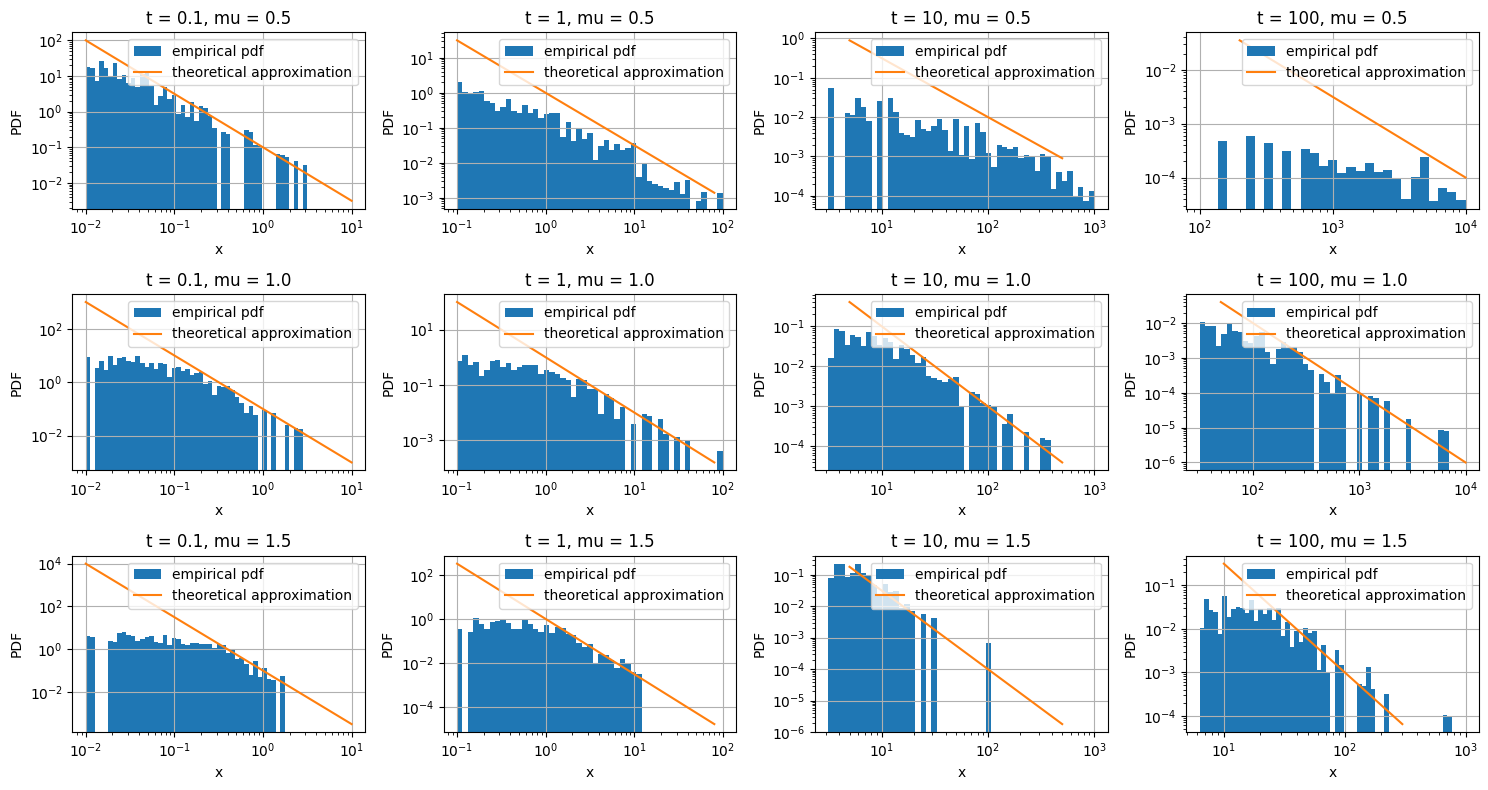

In [88]:
ts = [0.1, 1, 10, 100]
fig, axes = plt.subplots(len(mus) - 1, len(ts), figsize=(15, 8))
N = 2*10**2


for j, mu in enumerate(mus[:-1]):
    scale = (K_mu*dt)**(1 / mu)
    samples = alpha_stable_sample(mu, size=(N, int(ts[-1] / dt) + 1))
    samples[:, 0] = x0
    mu_trajectory = scale * np.cumsum(samples, axis=1)

    for i, t in enumerate(ts):
        idx = int(t // dt)
        bins = np.array([(1 + 1e-1)**n-1 for n in range(0, 200)])

        if t == 0.1:
            bins = 10**np.linspace(-2, 0.5, 50)
            x = np.linspace(1e-2, 10, 100)
        elif t == 1:
            bins = 10**np.linspace(-1, 2, 50)
            x = np.linspace(1e-1, 80, 100)
        elif t == 10:
            bins = 10**np.linspace(0.5, 3, 50)
            x = np.linspace(5, 500, 100)
        elif t == 100:
            if mu == 0.5:
                bins = 10**np.linspace(2, 4, 30)
                x = np.linspace(200, 10**4, 100)
            elif mu == 1:
                bins = 10**np.linspace(1.5, 4, 50)
                x = np.linspace(50, 10**4, 100)
            else:
                bins = 10**np.linspace(0.8, 3, 60)
                x = np.linspace(10, 3*10**2, 100)

        axes[j][i].hist(np.abs(mu_trajectory[:, idx]), density=True, bins=bins, label='empirical pdf')
        axes[j][i].plot(x, asymptotic(x, t, mu, K_mu), label='theoretical approximation')
        
        axes[j][i].grid()
        axes[j][i].set_title(f't = {t}, mu = {mu}')
        axes[j][i].set_xlabel('x')
        axes[j][i].set_ylabel('PDF')
        axes[j][i].set_xscale('log')
        axes[j][i].set_yscale('log')
        axes[j][i].legend()

plt.tight_layout()
plt.show()